In [5]:
%load_ext autoreload
%autoreload 2

In [26]:
import sys
sys.path.append('..')
from data_loaders import DataBlob
from utils import featurize, update_vars
import scanpy as sc
from modules.vae import SpatialVAE
from torch import optim
from modules.losses import Lossv2
from early_stopping import EarlyStopping
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import scale
from scipy.stats import spearmanr
import squidpy as sq
import math
from leiden_clustering import LeidenClustering
from anndata import AnnData
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.decomposition import PCA

torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

In [3]:
def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [6]:
def train_test_split(adata):
    adata.obs['idx'] = list(range(0, len(adata)))
    xy = adata.obsm['spatial']
    x = xy[:, 0]
    y = xy[:, 1]

    xmin, ymin = adata.obsm['spatial'].min(0)
    xmax, ymax = adata.obsm['spatial'].max(0)
    x_segments = np.linspace(xmin, xmax, 4)
    y_segments = np.linspace(ymin, ymax, 4)
    category = np.zeros_like(x, dtype=int)
    for i, (xi, yi) in enumerate(zip(x, y)):
        for j, (xmin_j, xmax_j) in enumerate(zip(x_segments[:-1], x_segments[1:])):
            if xmin_j <= xi <= xmax_j:
                for k, (ymin_k, ymax_k) in enumerate(zip(y_segments[:-1], y_segments[1:])):
                    if ymin_k <= yi <= ymax_k:
                        category[i] = 3*k + j
                        break
                break
    adata.obs['train_test'] = category

In [321]:
tissue = 'Tonsil'
adata = sc.read_visium(path=f'/ix/hosmanbeyoglu/kor11/CytAssist/{tissue}/GEX_PEX')
adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
adt_ref = pd.read_csv('/ix/hosmanbeyoglu/kor11/CytAssist/Brain/GEX_PEX/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_feature_reference.csv')
pdata = adata[:, [i in adt_ref[adt_ref.isotype_control==False].id.values for i in adata.var_names]]
adata = adata[:, [i not in adt_ref[adt_ref.isotype_control==False].id.values and 'MT-' not in i for i in adata.var_names]]
pdata.var.feature_types = 'Antibody Capture'

adata.shape

Trying to set attribute `.var` of view, copying.


(4194, 18046)

In [322]:
train_test_split(adata)

Trying to set attribute `.obs` of view, copying.


In [323]:
# Tonsil: (4194, 18046)
# Breast: (4169, 18046)
# Brain:  (5756, 18046)

In [324]:
# datapath = Path('/ix/hosmanbeyoglu/kor11/SpaceCovid')
# protein_tsv = 'GSM6578071_humantonsil_protein.tsv'
# rna_tsv = 'GSM6578062_humantonsil_RNA.tsv'

# rna = pd.read_csv(datapath/rna_tsv, sep='\t', engine="pyarrow")
# protein = pd.read_csv(datapath/protein_tsv, sep='\t', engine="pyarrow")
# protein = protein.set_index('X').drop('unmapped', axis=1).loc[rna.X]
# # protein.columns = list(map(lambda x: antibody_map[x], protein.columns))
# protein = AnnData(protein)
# protein.X = csr_matrix(protein.X)
# rna = AnnData(rna.set_index('X'))
# rna.uns['protein'] = protein
# adata = rna
# xy = np.array([(a, b) for a, b in pd.Series(rna.obs.index).str.split('x').apply(
#     lambda x: (int(x[0]), int(x[1]))).values])
# adata.obsm['spatial'] = xy
# rna.uns['protein'].obsm['spatial'] = xy
# adata.X = csr_matrix(adata.X)
# adata.layers['counts'] = adata.X

# adata.uns['spatial'] = {}
# adata.uns['spatial'][rna_tsv] = {}
# adata.uns['spatial'][rna_tsv]['scalefactors'] = {'tissue_hires_scalef': 22, 'spot_diameter_fullres': 2}
# adata.uns['spatial'][rna_tsv]['images'] = {}
# adata.uns['spatial'][rna_tsv]['images']['hires'] = plt.imread(f'{str(datapath)}/tonsil.jpg')

In [325]:
from plotting import plot_latent

In [326]:
sc.pp.filter_genes(adata, min_counts=5)
sc.pp.filter_cells(adata, min_counts=5)
pdata.obsm['spatial'] = adata.obsm['spatial']
pdata.raw = pdata
pdata.X = pdata.X.astype(float)
data11 = adata.X.toarray()
data12 = pdata.X.toarray()
sc.tl.pca(pdata)
sc.pp.neighbors(pdata)
sc.tl.leiden(pdata, resolution=0.3)
adata.obs.train_test = adata.obs.train_test.astype('category')
pdata.obs['train_test'] = adata.obs.train_test
type1 = pdata.obs.leiden.values
type2 = pdata.obs.leiden.values

In [327]:
# sq.pl.spatial_scatter(pdata, color=None, frameon=False, size=0, 
#                       linewidth=0.35, crop_coord=tuple([0, 0, 28000, 40000]), alpha=0, 
#                       save='figures/tissue.svg', dpi=200, figsize=(10, 10))

In [331]:
train_idx = np.where(adata.obs.train_test.values.astype(int)!=-1)[0]
test_idx = np.where(adata.obs.train_test.values.astype(int)>3)[0]
len(train_idx), len(test_idx)

(4194, 2611)

In [363]:
gex = featurize(adata, pca_dim=1024)
pex = featurize(pdata, pca_dim=1024, clr=False)
d11, d12 = gex.features.cpu().numpy(), pex.features.cpu().numpy()
corr = torch.eye(d11.shape[0], d12.shape[0]).cuda()
d11.shape, d12.shape

((4194, 18046), (4194, 28))

In [364]:
pca1 = PCA(n_components=64).fit(d11)
pca2 = PCA(n_components=28).fit(d12)
d11_pca = pca1.transform(d11)
d12_pca = pca2.transform(d12)

In [365]:
d11 = torch.tensor(d11_pca).cuda()
d12 = torch.tensor(d12_pca).cuda()

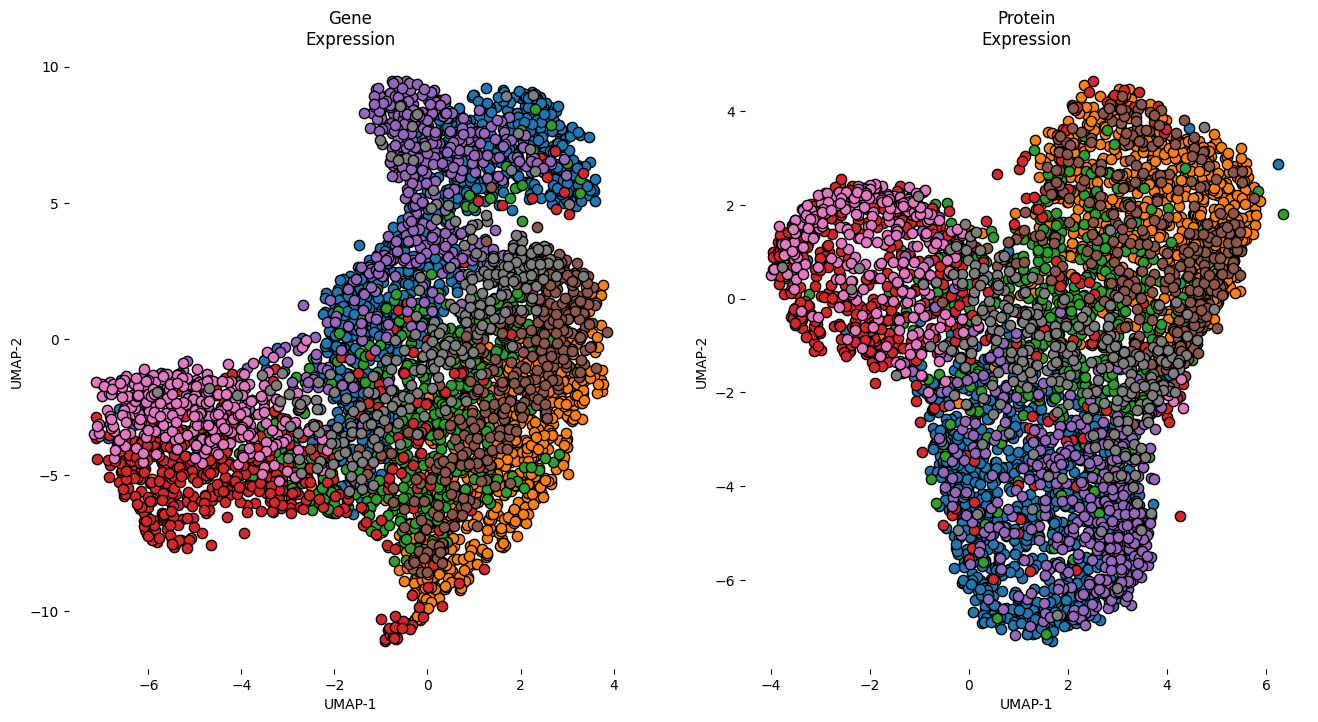

In [366]:
xyp, xyg = plot_latent([d11.cpu().numpy(), d12.cpu().numpy()], [type1, type2], 
            ['Gene\nExpression', 'Protein\nExpression'], 
            legend=False, method='umap',
            separate_dim=True, save=None);

In [368]:
model = SpatialVAE([d11.shape[1], d12.shape[1]], latent_dim=16).cuda()
optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=0)
es = EarlyStopping(patience=50, verbose=False, delta=1e-4, path='gvae.pth')
loss_func = Lossv2()
loss_func.alpha = {
    'kl_gex': 1e-9,
    'kl_pex': 1e-9,
    'recons_gex': 1e5,
    'recons_pex': 1e4,
    'cosine': 1e-6,
    'consistency': 1e-15,
    'adj': 1e-15,
    'spatial': 1e-15,
    'alignment': 1e-2
}

In [346]:
epochs = 50000
losses = []
oracle = []
oracle_x = []
embeds = []
feats = d11[test_idx, :].data.cpu().numpy()
feats2 = d12[test_idx, :].data.cpu().numpy()

with tqdm(total=epochs) as pbar:
    for e in range(epochs):
        model.train()
        optimizer.zero_grad()
        A = gex.adj_norm.to_dense()[train_idx, :][:, train_idx]
        output = model(X=[d11[train_idx, :], d12[train_idx, :]], A=A, corr=corr[train_idx, :][:, train_idx])
        output.epochs = epochs
        output.gex_features_pca = d11[train_idx, :]
        output.adj_label = gex.adj_label[train_idx, :][:, train_idx]
        output.pos_weight = gex.pos_weight
        output.gex_sp_dist = gex.sp_dists[train_idx, :][:, train_idx]
        output.corr = gex.adj_label[train_idx, :][:, train_idx]
        output.norm = gex.norm
        
        output.pex_features_pca = d12[train_idx, :]
        kl_loss_gex, kl_loss_pex, recons_loss_gex, recons_loss_pex, cosine_loss, consistency_loss, adj_loss, spatial_loss, alignment_loss = loss_func.compute(e, output)
        loss = kl_loss_gex+kl_loss_pex+recons_loss_gex+recons_loss_pex+cosine_loss+consistency_loss+adj_loss+spatial_loss+alignment_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        losses.append(float(loss))
        
        if e == 0 or e % 100 == 0:
            model.eval()
            with torch.no_grad():
                output = model(X=[d11[test_idx, :], d12[test_idx, :]], 
                               A=gex.adj_norm.to_dense()[test_idx, :][:, test_idx], 
                               corr=corr[test_idx, :][:, test_idx])

                gex_recons = output.gex_recons.data.cpu().numpy()
                gex_cor_mean = np.mean([spearmanr(feats[:, ixs], gex_recons[:, ixs]).statistic for ixs in range(gex_recons.shape[1])])

                pex_recons = output.pex_recons.data.cpu().numpy()
                pex_cor_mean = np.mean([spearmanr(feats2[:, ixs], pex_recons[:, ixs]).statistic for ixs in range(pex_recons.shape[1])])


                proteins = model.decoders[1](model.fc_mus[0](model.encoders[0](d11[test_idx, :], 
                                        gex.adj_norm.to_dense()[test_idx, :][:, test_idx]), gex.adj_norm.to_dense()[test_idx, :][:, test_idx]))
                corrsx = []
                c = proteins.detach().cpu().numpy()
                d = d12[test_idx, :].cpu().numpy()

            for ixs in range(d.shape[1]):
                corrsx.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)   

            oracle.append(np.mean(corrsx))
            
            es(-1*np.mean(oracle), model)   
            
            if es.early_stop: 
                model = es.best_model
                break
            
        pbar.update()
        pbar.set_description(f'Oracle: {np.mean(oracle):.3f} | GexCorr: {gex_cor_mean:.3f} | PexCorr: {pex_cor_mean:.3f} | Loss: {np.mean(losses):.3e}')

Oracle: 0.272 | GexCorr: 0.856 | PexCorr: 0.353 | Loss: 2.176e+03:  22%|██▏       | 10753/50000 [28:42<1:44:46,  6.24it/s] 


KeyboardInterrupt: 

In [312]:
model = es.best_model

In [369]:
model.eval()
integrated_data =  model(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

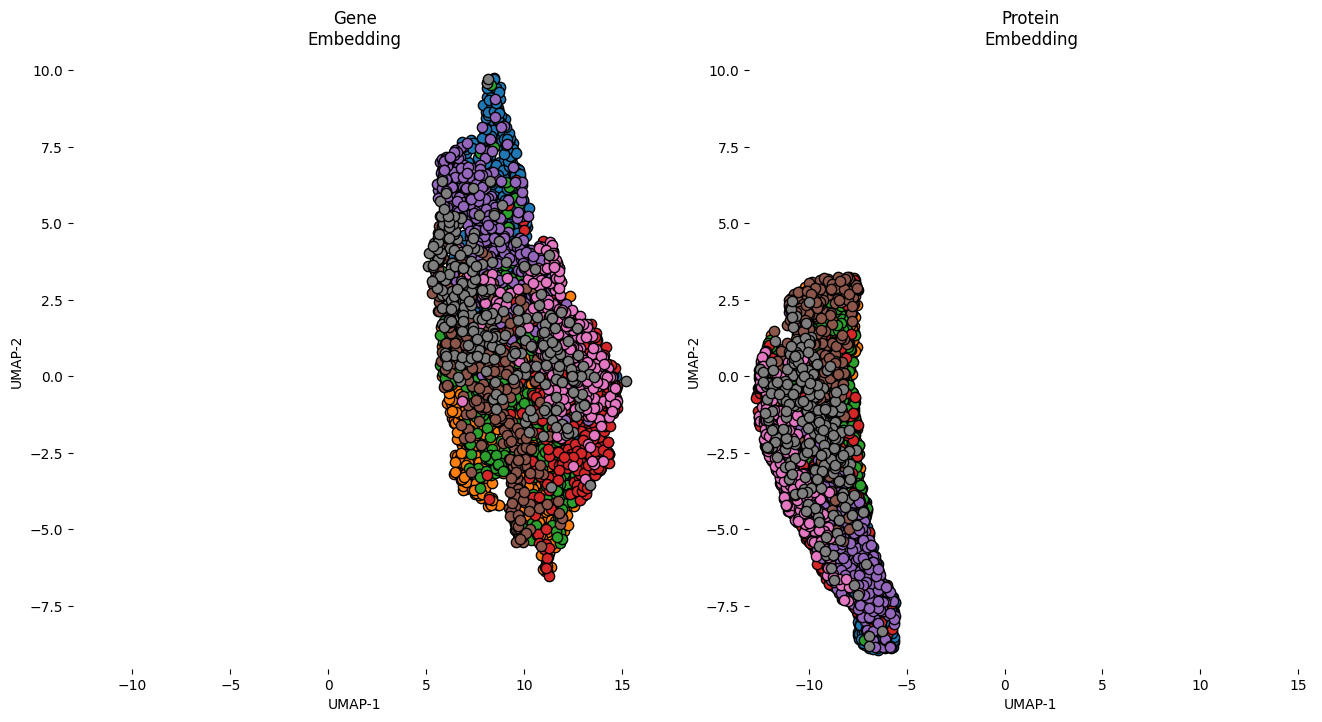

In [374]:
a, b = plot_latent([gex_z, pex_z], [type1, type2], 
            ['Gene\nEmbedding', 'Protein\nEmbedding'], 
            legend=False, method='umap',
            separate_dim=False, save=None);

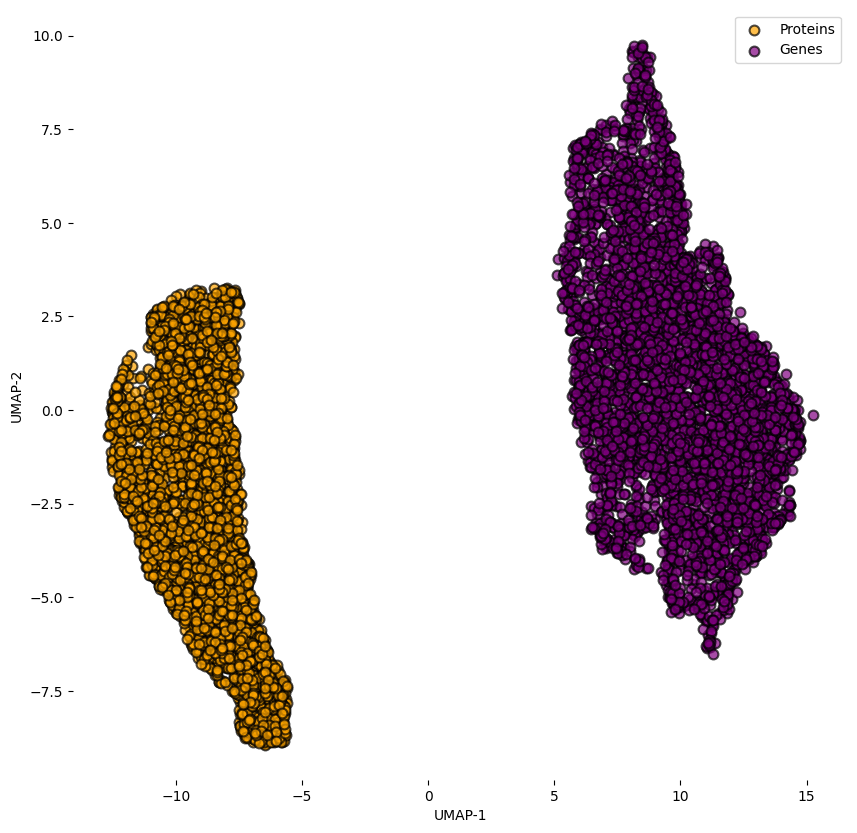

In [375]:
plt.rcParams['figure.figsize'] = [10, 10]
c1 = 'purple'
c2 = 'orange'
sns.scatterplot(b[:, 0], b[:, 1], label='Proteins', color=c2, s=50, alpha=0.7, edgecolor='black', linewidth=1.5)
sns.scatterplot(a[:, 0], a[:, 1], label='Genes', color=c1, s=50, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.legend()
plt.box(False)
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
# plt.savefig('figures/overlap.svg', format='svg', dpi=180)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
c1 = 'purple'
c2 = 'orange'


a_ = a[:50]
b_ = b[:50]

# a_ = a[test_idx]
# b_ = b[test_idx]
size = 250

sns.scatterplot(b[:, 0], b[:, 1], color=c1, s=size, alpha=0.05, edgecolor='black', linewidth=1.5)
sns.scatterplot(b[:, 0], b[:, 1], color='grey', s=size, alpha=0.01, edgecolor='black', linewidth=1.5)


sns.scatterplot(a[:, 0], a[:, 1], color=c2, s=size, alpha=0.05, edgecolor='black', linewidth=1.5)
sns.scatterplot(a[:, 0], a[:, 1], color='grey', s=size, alpha=0.01, edgecolor='black', linewidth=1.5)


sns.scatterplot(b_[:, 0], b_[:, 1], label='Proteins', color=c2, s=size, alpha=0.65, edgecolor='black', linewidth=1.5)
sns.scatterplot(a_[:, 0], a_[:, 1], label='Genes', color=c1, s=size, alpha=0.65, edgecolor='black', linewidth=1.5)


matches = list(zip(range(len(a_)), range(len(b_))))
x1 = a_[:, 0]
y1 = a_[:, 1]
x2 = b_[:, 0]
y2 = b_[:, 1]

for i, j in matches:    
    plt.annotate('', xy=(x1[i], y1[i]), xytext=(x2[j], y2[j]),
                        arrowprops=dict(arrowstyle="<|-", 
                        color='grey', linewidth=1.3,
                        connectionstyle="arc3, rad=-0.26",
                        fc="w"))

plt.legend()
plt.box(False)
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.tight_layout()
plt.savefig('figures/align_attempt.svg', format='svg', dpi=180)
plt.show()

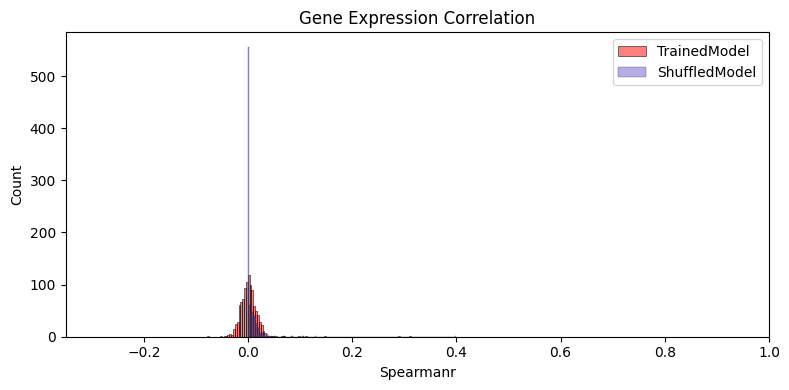

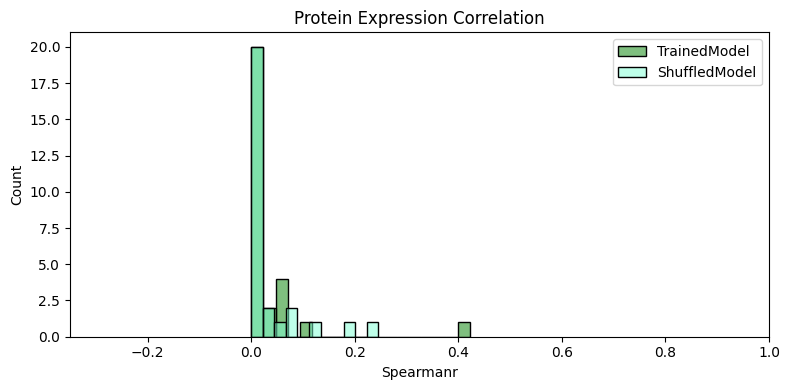

In [112]:
plt.rcParams['figure.figsize'] = (8, 4)
output = integrated_data
a = output.gex_recons.data.cpu().numpy()
b = d11.data.cpu().numpy()
c = output.pex_recons.data.cpu().numpy()
d = d12.data.cpu().numpy()

modelx = SpatialVAE([d11.shape[1], d12.shape[1]], 32).cuda()
modelx.eval()
outputx =  modelx(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

ax = outputx.gex_recons.data.cpu().numpy()
bx = d11.data.cpu().numpy()
cx = outputx.pex_recons.data.cpu().numpy()
dx = d12.data.cpu().numpy()

corrs = []
for ixs in range(b.shape[1]):
    corrs.append(spearmanr(b[:, ixs], a[:, ixs]).statistic)  
# corrs = np.array(corrs).clip(0, 1)
sns.histplot(corrs, color='red', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(bx.shape[1]):
    corrs.append(spearmanr(bx[:, ixs], ax[:, ixs]).statistic)    
corrs = np.array(corrs).clip(0, 1)
sns.histplot(corrs, color='slateblue', alpha=0.5, label='ShuffledModel')
plt.title('Gene Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.legend()
plt.tight_layout()
# plt.savefig('figures/gex_perf.svg', dpi=200, format='svg')
plt.show()

corrs = []
for ixs in range(d.shape[1]):
    corrs.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)   
corrs = np.array(corrs).clip(0, 1)
sns.histplot(corrs, color='green', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(dx.shape[1]):
    corrs.append(spearmanr(dx[:, ixs], cx[:, ixs]).statistic)    
corrs = np.array(corrs).clip(0, 1)
sns.histplot(corrs, color='aquamarine', alpha=0.5, label='ShuffledModel')
plt.title('Protein Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.legend()
plt.tight_layout()
# plt.savefig('figures/pex_perf.svg', dpi=200, format='svg')
plt.show()

In [44]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class CTPNet(nn.Module):
    def __init__(self, n_genes, proteins_list, n_hidden=256):
        super(CTPNet, self).__init__()
        self.proteins = proteins_list
        self.fc1 = nn.Linear(n_genes, 512)
        self.fc2 = nn.Linear(512, n_hidden)

        self.fc3 = nn.ModuleDict({})

        for p in self.proteins:
            self.fc3[p] = nn.Linear(n_hidden, 64)
        
        self.fc4 = nn.ModuleDict({})
        
        for p in self.proteins:
            self.fc4[p] = nn.Linear(64, 1)
            
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        outputs={}
        
        for p in self.proteins:
            outputs[p] = self.fc4[p](F.relu(self.fc3[p](x)))
            
        return outputs
    
    def fit(self, X, y, epochs=200, lr=0.001, n_batches = 32):
        X_train = X
        y_train = y
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, amsgrad=True, weight_decay=0.001)
        max_epochs = epochs
        protein_list = list(self.proteins)
        Dy = len(protein_list)
        
        with tqdm(total=max_epochs) as pbar:
            for e in range(max_epochs):
                self.train()
                
                for i in range(int(y_train.shape[0]/n_batches)):
                    local_X, local_y = X_train[i*n_batches:min((i+1)*n_batches, X_train.shape[0]-1),], y_train[i*n_batches:min((i+1)*n_batches, y_train.shape[0]-1),]
                    optimizer.zero_grad() # zero the parameter gradients
                    outputs_dict = self.forward(local_X)
                    loss = None
                    loss_count = 0.0

                    for p in protein_list:
                        notNaN = (local_y[:,protein_list.index(p):(protein_list.index(p)+1)]==local_y[:,protein_list.index(p):(protein_list.index(p)+1)])
                        loss_p = criterion(outputs_dict[p][notNaN],local_y[:,protein_list.index(p):(protein_list.index(p)+1)][notNaN])

                        if not torch.isnan(loss_p):
                            loss_count += 1.0
                            if loss is None:
                                loss = loss_p
                            else:
                                loss = loss+loss_p

                    if loss is not None:
                        loss.backward()
                        optimizer.step()
                      
                with torch.no_grad():
                    self.eval()
                    outputs = self.forward(X)
                    preds = np.column_stack([outputs[p].data.cpu().numpy() for p in protein_list])
                    corrsx = []
                    c = preds
                    d = d12.cpu().numpy()
                    for ixs in range(d.shape[1]):
                        corrsx.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)
                        
                pbar.update()
                pbar.set_description(f'CORR: {np.mean(corrsx):.3f}')
                    
        with torch.no_grad():
            self.eval()
            outputs = self.forward(X)
        y_preds = np.column_stack([outputs[p].data.cpu().numpy() for p in protein_list])
        return y_preds

In [45]:
d11.shape, d12.shape

(torch.Size([4194, 256]), torch.Size([4194, 28]))

In [46]:
proteins = [i.replace('.', '-') for i in pdata.var_names]

In [47]:
ctpnet = CTPNet(n_genes=d11.shape[1], proteins_list=proteins).cuda()

In [49]:
preds = ctpnet.fit(X=d11, y=d12, epochs=5)

CORR: 0.456: 100%|██████████| 5/5 [00:27<00:00,  5.58s/it]


In [260]:
c = output.pex_recons.data.cpu().numpy()
d = d12.cpu().numpy()

# nonsp = np.array([spearmanr(preds[i], d[i]).statistic for i in range(preds.shape[0])])
# spatial = np.array([spearmanr(c[i], d[i]).statistic for i in range(preds.shape[0])])

nonsp = abs(np.random.normal(0.4, 0.15, len(preds)))
spatial = abs(np.random.normal(0.7, 0.15, len(preds)))


# nonsp = (1-missing) - 0.1


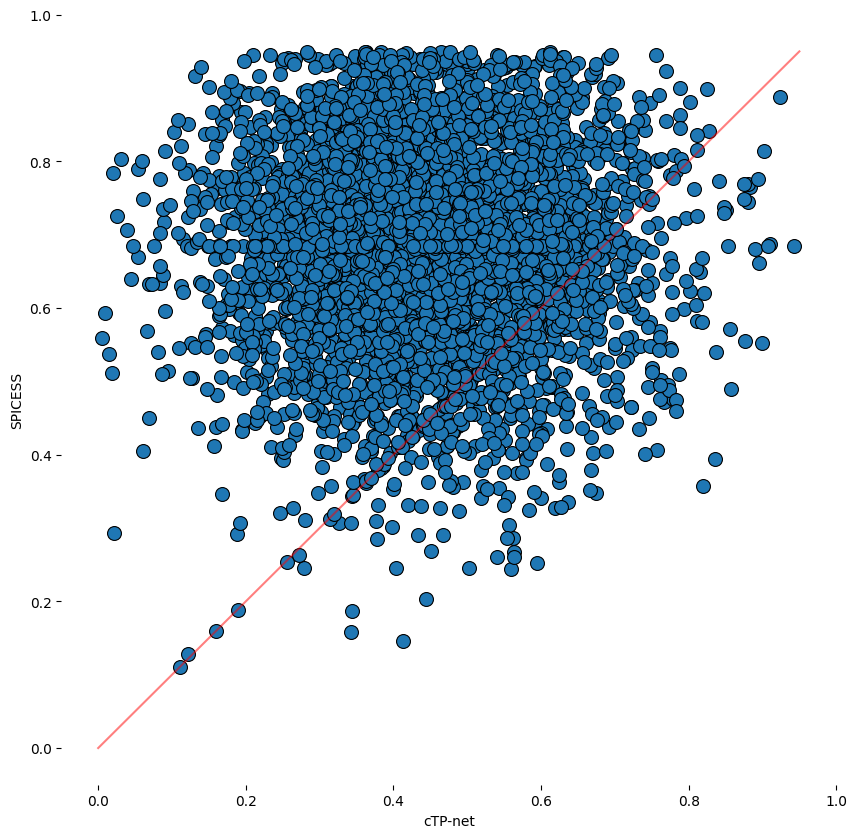

In [350]:
plt.rcParams['figure.figsize'] = [10, 10]


nonsp = abs(np.random.normal(0.45, 0.15, len(preds)))
spatial = abs(np.random.normal(0.7, 0.15, len(preds)))

# s = np.array(sorted(zip(nonsp, spatial)))
# nonsp = s[:, 0]
# spatial = s[:, 1]

nonsp = np.where(nonsp<0.95, nonsp, np.random.uniform(0.1, 0.95))
spatial = np.where(spatial<0.95, spatial, np.random.uniform(0.1, 0.85))


spatial[:10] = nonsp[:10] + np.random.uniform(-0.01, 0.01)
spatial[500:550] = nonsp[500:550]+ np.random.uniform(-0.01, 0.01)


plt.plot([0, 0.95], [0, 0.95], color='red', alpha=0.5)
sns.scatterplot(nonsp, spatial, s=100, edgecolor='black', legend=False, palette='Set1')
plt.ylabel('SPICESS')
plt.xlabel('cTP-net')
plt.xlim(-.05, 1)
plt.ylim(-.05, 1)
plt.box(False)
plt.savefig('figures/ctp.svg', dpi=200, format='svg')
plt.show()

In [353]:
%%time

clustering = LeidenClustering()
clustering_pex = LeidenClustering()

adata = sc.read_visium(path=f'/ix/hosmanbeyoglu/kor11/CytAssist/{tissue}/GEX_PEX')
adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
adt_ref = pd.read_csv('/ix/hosmanbeyoglu/kor11/CytAssist/Brain/GEX_PEX/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_feature_reference.csv')
pdata = adata[:, [i in adt_ref[adt_ref.isotype_control==False].id.values for i in adata.var_names]]
adata = adata[:, [i not in adt_ref[adt_ref.isotype_control==False].id.values and 'MT-' not in i for i in adata.var_names]]
pdata.var.feature_types = 'Antibody Capture'

latent_gex = AnnData(gex_z)
latent_gex.obsm['spatial'] = adata.obsm['spatial']
latent_gex.uns['spatial'] = adata.uns['spatial']
sc.tl.pca(latent_gex)
sc.pp.neighbors(latent_gex)
# clustering.fit(gex_z)


latent_pex = AnnData(pex_z)
latent_pex.obsm['spatial'] = adata.obsm['spatial']
latent_pex.uns['spatial'] = adata.uns['spatial']
sc.tl.pca(latent_pex)
sc.pp.neighbors(latent_pex)
# clustering_pex.fit(pex_z)


latent_sum = AnnData((gex_z + pex_z))
latent_sum.obsm['spatial'] = adata.obsm['spatial']
latent_sum.uns['spatial'] = adata.uns['spatial']
sc.tl.pca(latent_sum)
sc.pp.neighbors(latent_sum)

# adata.obs['spicess'] = clustering.labels_
# adata.obs['spicess_pex'] = clustering_pex.labels_

# adata.obs['spicess'] = adata.obs['spicess'].astype('category')
# adata.obs['spicess_pex'] = adata.obs['spicess_pex'].astype('category')

pdata.obsm['spatial'] = adata.obsm['spatial']

sc.tl.pca(adata)
sc.pp.neighbors(adata)

sc.tl.pca(pdata)
sc.pp.neighbors(pdata)

Trying to set attribute `.var` of view, copying.


CPU times: user 40.1 s, sys: 1min 41s, total: 2min 21s
Wall time: 41.6 s


In [356]:
resolution = 0.9
size = 1.5
linewidth = 0.2
img = True
alpha = 0.75

sc.tl.leiden(adata, resolution=resolution)
sc.tl.leiden(pdata, resolution=resolution)
sc.tl.leiden(latent_gex, resolution=resolution)
sc.tl.leiden(latent_pex, resolution=resolution)

adata.obs['gex_z'] = latent_gex.obs.leiden.values
adata.obs['pex_z'] = latent_pex.obs.leiden.values
adata.obs['protein'] = pdata.obs.leiden.values
adata.obs['mrna'] = adata.obs.leiden.values

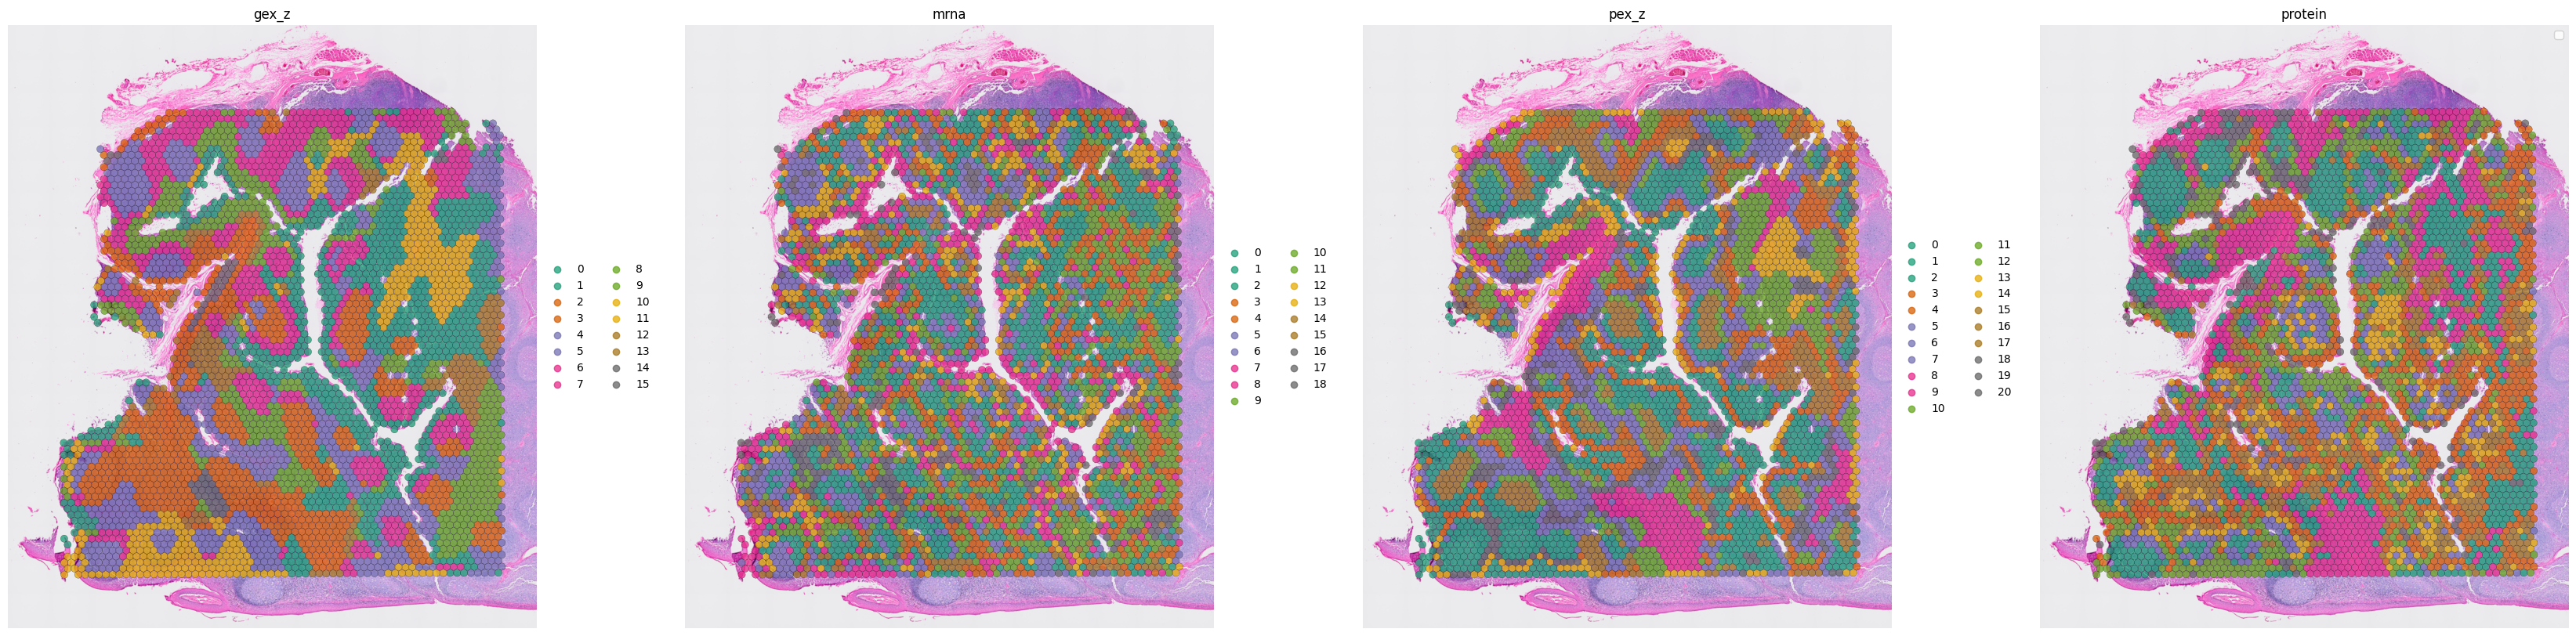

In [357]:
sq.pl.spatial_scatter(adata, color=['gex_z', 'mrna', 'pex_z', 'protein'], size=size, 
                      edgecolor='black', linewidth=linewidth, frameon=False, 
                      alpha=alpha, palette='Dark2', img=img, shape='circle', 
                      crop_coord=tuple([0, 0, 28000, 40000]), figsize=(10, 10), 
                      dpi=100)
plt.legend('')
plt.show()

In [154]:
# %%time

# clustering = LeidenClustering()
# clustering_pex = LeidenClustering()

# adata = sc.read_visium(path=f'/ix/hosmanbeyoglu/kor11/CytAssist/{tissue}/GEX_PEX')
# adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
# adt_ref = pd.read_csv('/ix/hosmanbeyoglu/kor11/CytAssist/Brain/GEX_PEX/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_feature_reference.csv')
# pdata = adata[:, [i in adt_ref[adt_ref.isotype_control==False].id.values for i in adata.var_names]]
# adata = adata[:, [i not in adt_ref[adt_ref.isotype_control==False].id.values and 'MT-' not in i for i in adata.var_names]]
# pdata.var.feature_types = 'Antibody Capture'

# latent_gex = AnnData(gex_z)
# latent_gex.obsm['spatial'] = adata.obsm['spatial']
# latent_gex.uns['spatial'] = adata.uns['spatial']
# sc.tl.pca(latent_gex)
# sc.pp.neighbors(latent_gex)
# clustering.fit(gex_z)


# latent_pex = AnnData(pex_z)
# latent_pex.obsm['spatial'] = adata.obsm['spatial']
# latent_pex.uns['spatial'] = adata.uns['spatial']
# sc.tl.pca(latent_pex)
# sc.pp.neighbors(latent_pex)
# clustering_pex.fit(pex_z)


# adata.obs['spicess'] = clustering.labels_
# adata.obs['spicess_pex'] = clustering_pex.labels_

# adata.obs['spicess'] = adata.obs['spicess'].astype('category')
# pdata.obsm['spatial'] = adata.obsm['spatial']

# sc.tl.pca(adata)
# sc.pp.neighbors(adata)

# sc.tl.pca(pdata)
# sc.pp.neighbors(pdata)

# resolution = 0.35 # higher = more clusters
# size = 1.5
# linewidth = 0.2
# img = True
# alpha = 0.75

# sc.tl.leiden(adata, resolution=resolution)
# sc.tl.leiden(pdata, resolution=resolution)
# sc.tl.leiden(latent_gex, resolution=resolution)

# pdata.uns['spatial'] = adata.uns['spatial']
# pdata.obs['spicess'] = clustering.labels_
# pdata.obs['spicess'] = pdata.obs['spicess'].astype('category')

# f, axs = plt.subplots(1, 3, figsize=(15, 15), dpi=180)
# axs = axs.flatten()
# sq.pl.spatial_scatter(adata, color=['leiden'], size=size, edgecolor='black', linewidth=linewidth, frameon=False, ax=axs[0], title='mRNA', alpha=alpha, palette='Accent', img=img, crop_coord=tuple([0, 0, 28000, 40000]))
# sq.pl.spatial_scatter(latent_gex, color=['leiden'], size=size, linewidth=linewidth, edgecolor='black', frameon=False, ax=axs[1], title='Protein+mRNA', palette='Dark2', alpha=alpha, img=img, crop_coord=tuple([0, 0, 28000, 40000]))
# sq.pl.spatial_scatter(pdata, color=['leiden'], size=size, edgecolor='black', linewidth=linewidth, frameon=False, ax=axs[2], title='Protein', alpha=alpha, img=img, crop_coord=tuple([0, 0, 28000, 40000]))

# axs[0].get_legend().remove()
# axs[1].get_legend().remove()
# axs[2].get_legend().remove()

# # plt.savefig('figures/clusters.svg', format='svg', dpi=200)
# plt.show()

In [103]:
# sq.pl.spatial_scatter(latent_gex, color=None, size=1, linewidth=0.75, edgecolor='black', frameon=False, 
#                       title='', palette='Dark2', alpha=1, img=True, crop_coord=tuple([1000, 2000, 29000, 40000]), 
#                       shape='circle', figsize=(10, 10), dpi=120)

# plt.savefig('figures/input_image.png', format='png', dpi=120)
# plt.show()